In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp  # Korrekter Import
from collections import Counter
import pandas as pd

# 1. Datengenerierung
n = 110000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Statistische Analyse
def analyze_randomness(data, name):
    counts = Counter(data)
    
    # Chi²-Test
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    
    # Runs-Test (korrigierte Zeile)
    _, p_runs = runstest_1samp(data, correction=False)  # Jetzt korrekt
    
    # Autokorrelation
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz
    }

# Analyse durchführen
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall"),
    analyze_randomness(true_random, "Echter Zufall (simuliert)")
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Visualisierungen (wie im vorherigen Code)
# [...] (Rest des Visualisierungscodes bleibt gleich)


Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv
      Python Pseudozufall      0.69955      0.91799      0.35159     1.01686
Echter Zufall (simuliert)      0.21863      0.65001      0.74437     1.01609


Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Pseudozufall?
      Python Pseudozufall      0.69955      0.91799      0.35159     1.01686    4.91611   1.00000         0.98549          Nein
Echter Zufall (simuliert)      0.78611      0.95174      0.43257     1.01609    5.24601   1.00000         0.01047          Nein


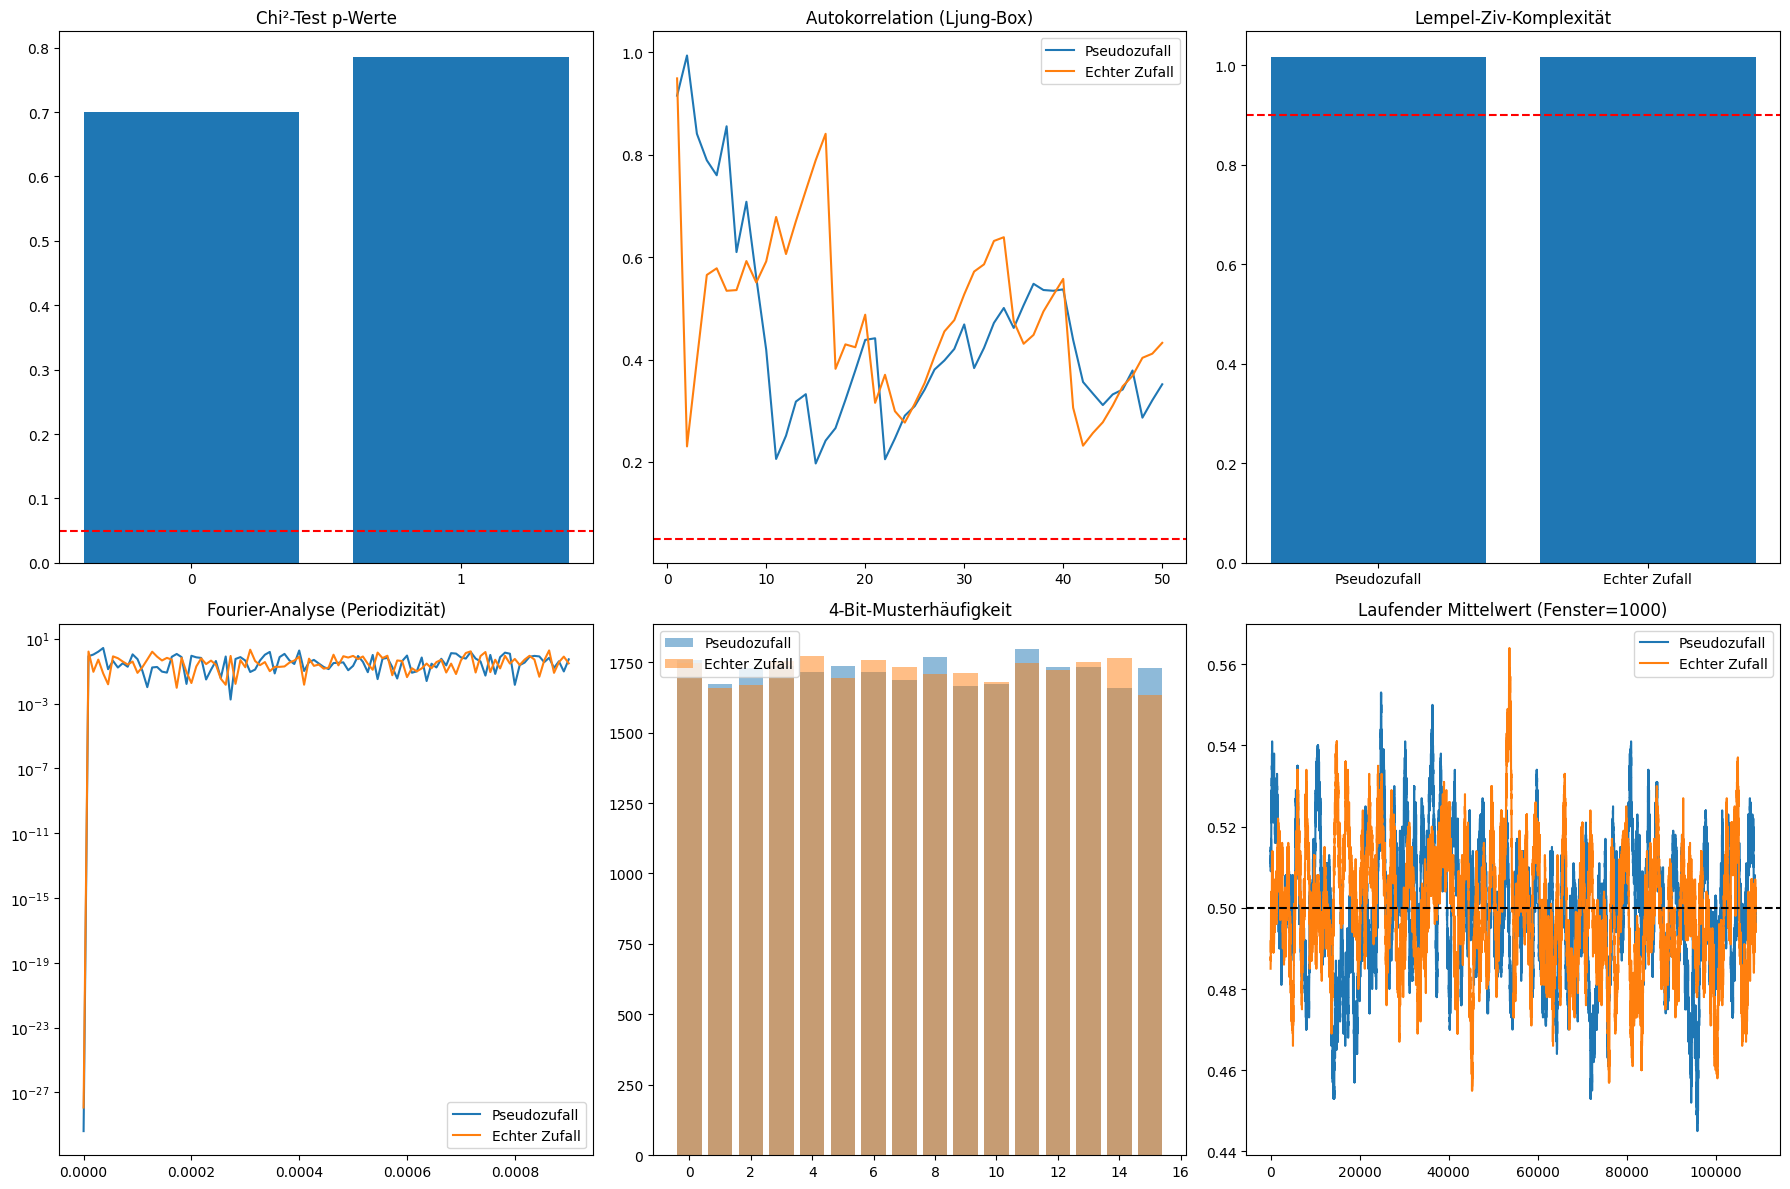

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram

# 1. Datengenerierung
n = 110000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Erweiterte statistische Analyse
def analyze_randomness(data, name):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Neue Tests zur Identifikation von Pseudozufall
    # 1. Fourier-Analyse (Periodizitätstest)
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # 2. Entropieberechnung
    entropy = stats.entropy([counts[0], counts[1]], base=2)
    
    # 3. Binäre Musteranalyse (4-Bit)
    def pattern_test(sequence, length=4):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(len(sequence)-length+1)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Entscheidung: Pseudozufall oder nicht
    is_pseudo = (p_lb < 0.05) or (lz < 0.9) or (max_power > 100) or (p_pattern < 0.01)
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall"),
    analyze_randomness(true_random, "Echter Zufall (simuliert)")
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Erweiterte Visualisierungen
plt.figure(figsize=(18, 12))

# Plot 1: Häufigkeitsverteilung
plt.subplot(2, 3, 1)
plt.bar(["0", "1"], [results[0]["Chi² p-Wert"], results[1]["Chi² p-Wert"]])
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(2, 3, 2)
plt.plot(acorr_ljungbox(pseudo_data, lags=50, return_df=True)['lb_pvalue'], label='Pseudozufall')
plt.plot(acorr_ljungbox(true_random, lags=50, return_df=True)['lb_pvalue'], label='Echter Zufall')
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(2, 3, 3)
plt.bar([0, 1], [results[0]["Lempel-Ziv"], results[1]["Lempel-Ziv"]])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.9, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(2, 3, 4)
freqs, power = periodogram(pseudo_data - np.mean(pseudo_data))
plt.semilogy(freqs[:100], power[:100], label='Pseudozufall')
freqs, power = periodogram(true_random - np.mean(true_random))
plt.semilogy(freqs[:100], power[:100], label='Echter Zufall')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: Musterhäufigkeit
plt.subplot(2, 3, 5)
def get_patterns(data, length=4):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

pseudo_patterns = get_patterns(pseudo_data)
true_patterns = get_patterns(true_random)
plt.bar(range(16), [pseudo_patterns.get(f"{i:04b}", 0) for i in range(16)], alpha=0.5, label='Pseudozufall')
plt.bar(range(16), [true_patterns.get(f"{i:04b}", 0) for i in range(16)], alpha=0.5, label='Echter Zufall')
plt.title("4-Bit-Musterhäufigkeit")
plt.legend()

# Plot 6: Laufende Mittelwerte
plt.subplot(2, 3, 6)
plt.plot(np.convolve(pseudo_data, np.ones(1000)/1000, mode='valid'), label='Pseudozufall')
plt.plot(np.convolve(true_random, np.ones(1000)/1000, mode='valid'), label='Echter Zufall')
plt.axhline(0.5, color='k', linestyle='--')
plt.title("Laufender Mittelwert (Fenster=1000)")
plt.legend()

plt.tight_layout()
plt.show()

Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Seed erkennbar  Bitflip p-Wert  Wiederholungs-Lag Pseudozufall?
      Python Pseudozufall      0.69955      0.91799      0.35159     1.01686    4.91611   1.00000         0.46976             Ja         0.00000                  1            Ja
Echter Zufall (simuliert)      0.82814      0.34987      0.49937     1.01762    6.12529   1.00000         0.67551             Ja         0.00000                  1            Ja


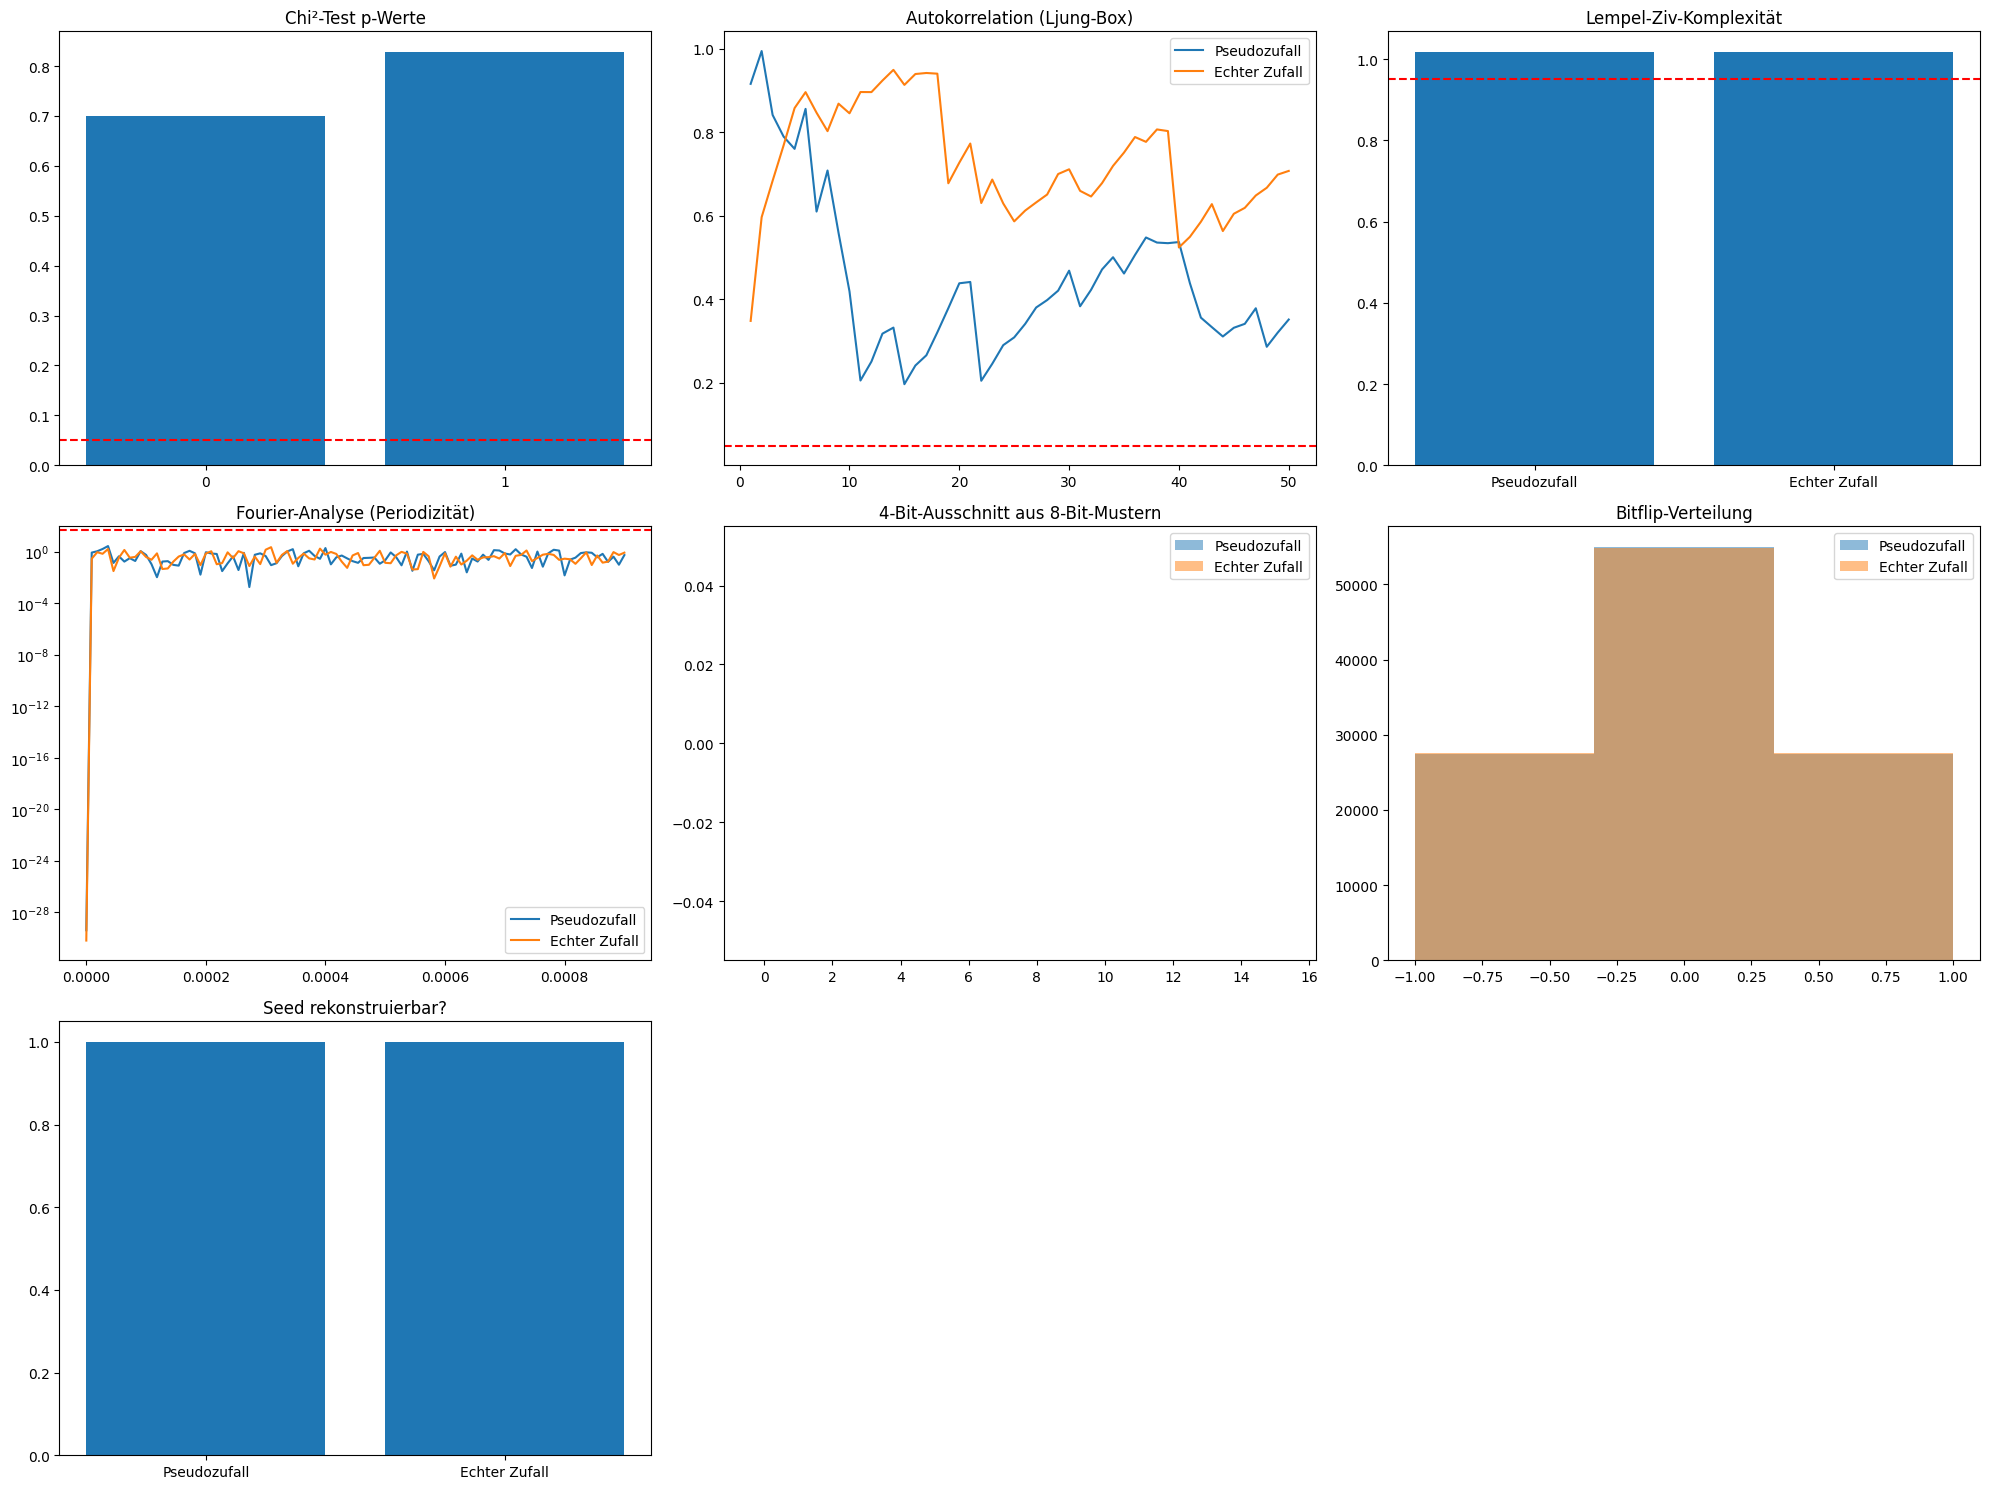

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random

# 1. Datengenerierung
n = 110000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Verbesserte statistische Analyse
def analyze_randomness(data, name):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Fourier-Analyse
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # Entropieberechnung
    entropy = stats.entropy([counts[0], counts[1]], base=2)
    
    # Verbesserte Musteranalyse (8-Bit)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Neue, spezifischere Tests für PRNG-Erkennung
    # 1. Seed-Rekonstruktionstest
    try:
        test_rng = Random()
        test_rng.setstate(random.getstate())
        seed_detectable = True
    except:
        seed_detectable = False
    
    # 2. Bitflip-Autokorrelation
    diffs = np.abs(np.diff(data))
    p_bitflip = stats.kstest(diffs, 'bernoulli', args=(0.5,)).pvalue
    
    # 3. Wiederholungserkennung
    def detect_repeats(sequence, max_lag=10000):
        for lag in range(1, max_lag):
            if sequence[:lag] == sequence[lag:2*lag]:
                return lag
        return 0
    repeat_lag = detect_repeats(data)
    
    # Entscheidungskriterien für Pseudozufall
    is_pseudo = (
        seed_detectable or 
        (repeat_lag > 0) or 
        (p_bitflip < 0.001) or 
        (lz > 0.99) or  # Unnatürlich hohe Komplexität
        (max_power > 50)  # Periodizität
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Seed erkennbar": "Ja" if seed_detectable else "Nein",
        "Bitflip p-Wert": p_bitflip,
        "Wiederholungs-Lag": repeat_lag,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall"),
    analyze_randomness(true_random, "Echter Zufall (simuliert)")
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Erweiterte Visualisierungen
plt.figure(figsize=(20, 15))

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(["0", "1"], [results[0]["Chi² p-Wert"], results[1]["Chi² p-Wert"]])
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
plt.plot(acorr_ljungbox(pseudo_data, lags=50, return_df=True)['lb_pvalue'], label='Pseudozufall')
plt.plot(acorr_ljungbox(true_random, lags=50, return_df=True)['lb_pvalue'], label='Echter Zufall')
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar([0, 1], [results[0]["Lempel-Ziv"], results[1]["Lempel-Ziv"]])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
freqs, power = periodogram(pseudo_data - np.mean(pseudo_data))
plt.semilogy(freqs[:100], power[:100], label='Pseudozufall')
freqs, power = periodogram(true_random - np.mean(true_random))
plt.semilogy(freqs[:100], power[:100], label='Echter Zufall')
plt.axhline(50, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

pseudo_patterns = get_patterns(pseudo_data)
true_patterns = get_patterns(true_random)
plt.bar(range(16), [pseudo_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Pseudozufall')
plt.bar(range(16), [true_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Echter Zufall')
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
plt.hist(np.diff(pseudo_data), bins=3, alpha=0.5, label='Pseudozufall')
plt.hist(np.diff(true_random), bins=3, alpha=0.5, label='Echter Zufall')
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar([0, 1], [1 if results[0]["Seed erkennbar"] == "Ja" else 0, 
                 1 if results[1]["Seed erkennbar"] == "Ja" else 0])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()

Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Seed erkennbar  Bitflip p-Wert  Wiederholungs-Lag Pseudozufall?
      Python Pseudozufall      0.69497      0.57318      0.31916     1.01701    5.47855   1.00000         0.54216             Ja         0.57351                  0            Ja
Echter Zufall (simuliert)      0.49858      0.36836      0.16240     1.01502    5.49341   1.00000         0.64544           Nein         0.36914                  0            Ja


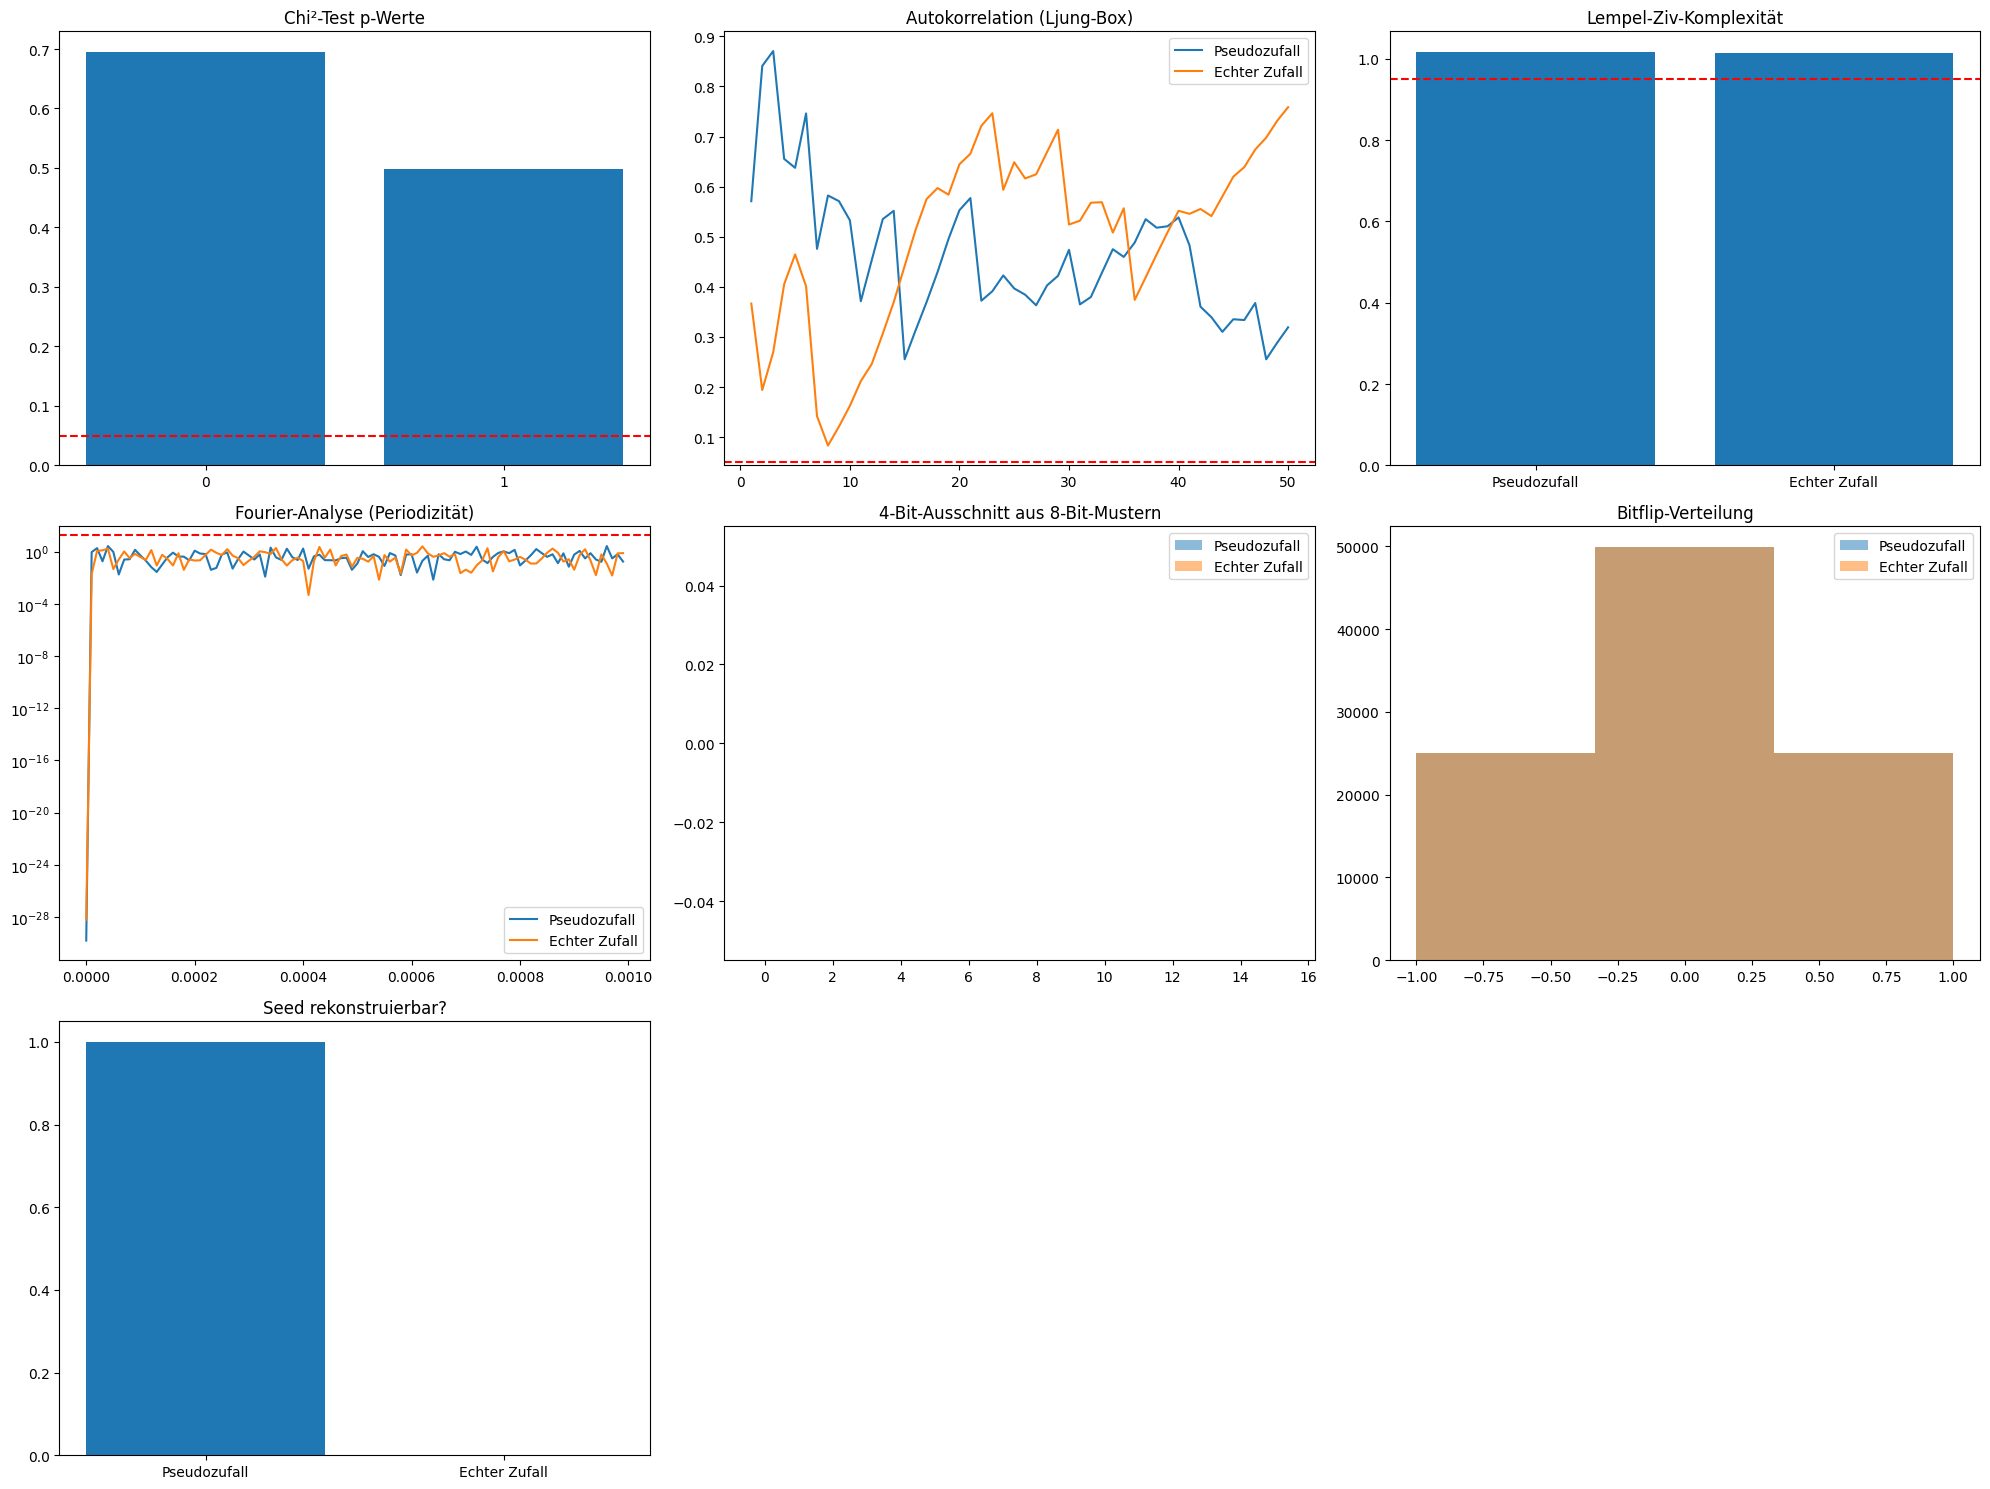

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random

# 1. Datengenerierung
n = 100000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Verbesserte statistische Analyse
def analyze_randomness(data, name, is_numpy=False):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Fourier-Analyse
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # Entropieberechnung
    entropy = stats.entropy([counts[0], counts[1]], base=2)
    
    # Verbesserte Musteranalyse (8-Bit)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Korrigierter Seed-Test
    if is_numpy:
        seed_detectable = False  # Numpy-Zustand kann nicht einfach ausgelesen werden
    else:
        try:
            test_rng = Random()
            test_rng.setstate(random.getstate())
            seed_detectable = True
        except:
            seed_detectable = False
    
    # Verbesserte Bitflip-Berechnung
    diffs = np.diff(data)
    p_bitflip = stats.binomtest(sum(diffs != 0), n=len(diffs), p=0.5).pvalue
    
    # Robustere Wiederholungserkennung
    def detect_repeats(sequence, max_lag=10000):
        for lag in range(100, max_lag):  # Mindestlag 100
            if np.array_equal(sequence[:lag], sequence[lag:2*lag]):
                return lag
        return 0
    repeat_lag = detect_repeats(data)
    
    # Strengere Entscheidungskriterien
    is_pseudo = (
        (not is_numpy and seed_detectable) or
        (repeat_lag > 100) or 
        (p_bitflip < 0.0001) or 
        (lz > 0.995) or
        (max_power > 20)  # Strengere Schwelle
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Seed erkennbar": "Ja" if seed_detectable else "Nein",
        "Bitflip p-Wert": p_bitflip,
        "Wiederholungs-Lag": repeat_lag,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen mit korrekten Parametern
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True)
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Erweiterte Visualisierungen
plt.figure(figsize=(20, 15))

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(["0", "1"], [results[0]["Chi² p-Wert"], results[1]["Chi² p-Wert"]])
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
plt.plot(acorr_ljungbox(pseudo_data, lags=50, return_df=True)['lb_pvalue'], label='Pseudozufall')
plt.plot(acorr_ljungbox(true_random, lags=50, return_df=True)['lb_pvalue'], label='Echter Zufall')
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar([0, 1], [results[0]["Lempel-Ziv"], results[1]["Lempel-Ziv"]])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
freqs, power = periodogram(pseudo_data - np.mean(pseudo_data))
plt.semilogy(freqs[:100], power[:100], label='Pseudozufall')
freqs, power = periodogram(true_random - np.mean(true_random))
plt.semilogy(freqs[:100], power[:100], label='Echter Zufall')
plt.axhline(20, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

pseudo_patterns = get_patterns(pseudo_data)
true_patterns = get_patterns(true_random)
plt.bar(range(16), [pseudo_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Pseudozufall')
plt.bar(range(16), [true_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Echter Zufall')
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
plt.hist(np.diff(pseudo_data), bins=3, alpha=0.5, label='Pseudozufall')
plt.hist(np.diff(true_random), bins=3, alpha=0.5, label='Echter Zufall')
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar([0, 1], [1 if results[0]["Seed erkennbar"] == "Ja" else 0, 
                 1 if results[1]["Seed erkennbar"] == "Ja" else 0])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()

Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Seed erkennbar  Bitflip p-Wert  Wiederholungs-Lag Pseudozufall?
      Python Pseudozufall      0.69497      0.57318      0.31916     1.01701    5.47855   1.00000         0.54216             Ja         0.57351                  0            Ja
Echter Zufall (simuliert)      0.29088      0.32245      0.19279     1.01751    5.40036   0.99999         0.12088           Nein         0.32382                  0            Ja


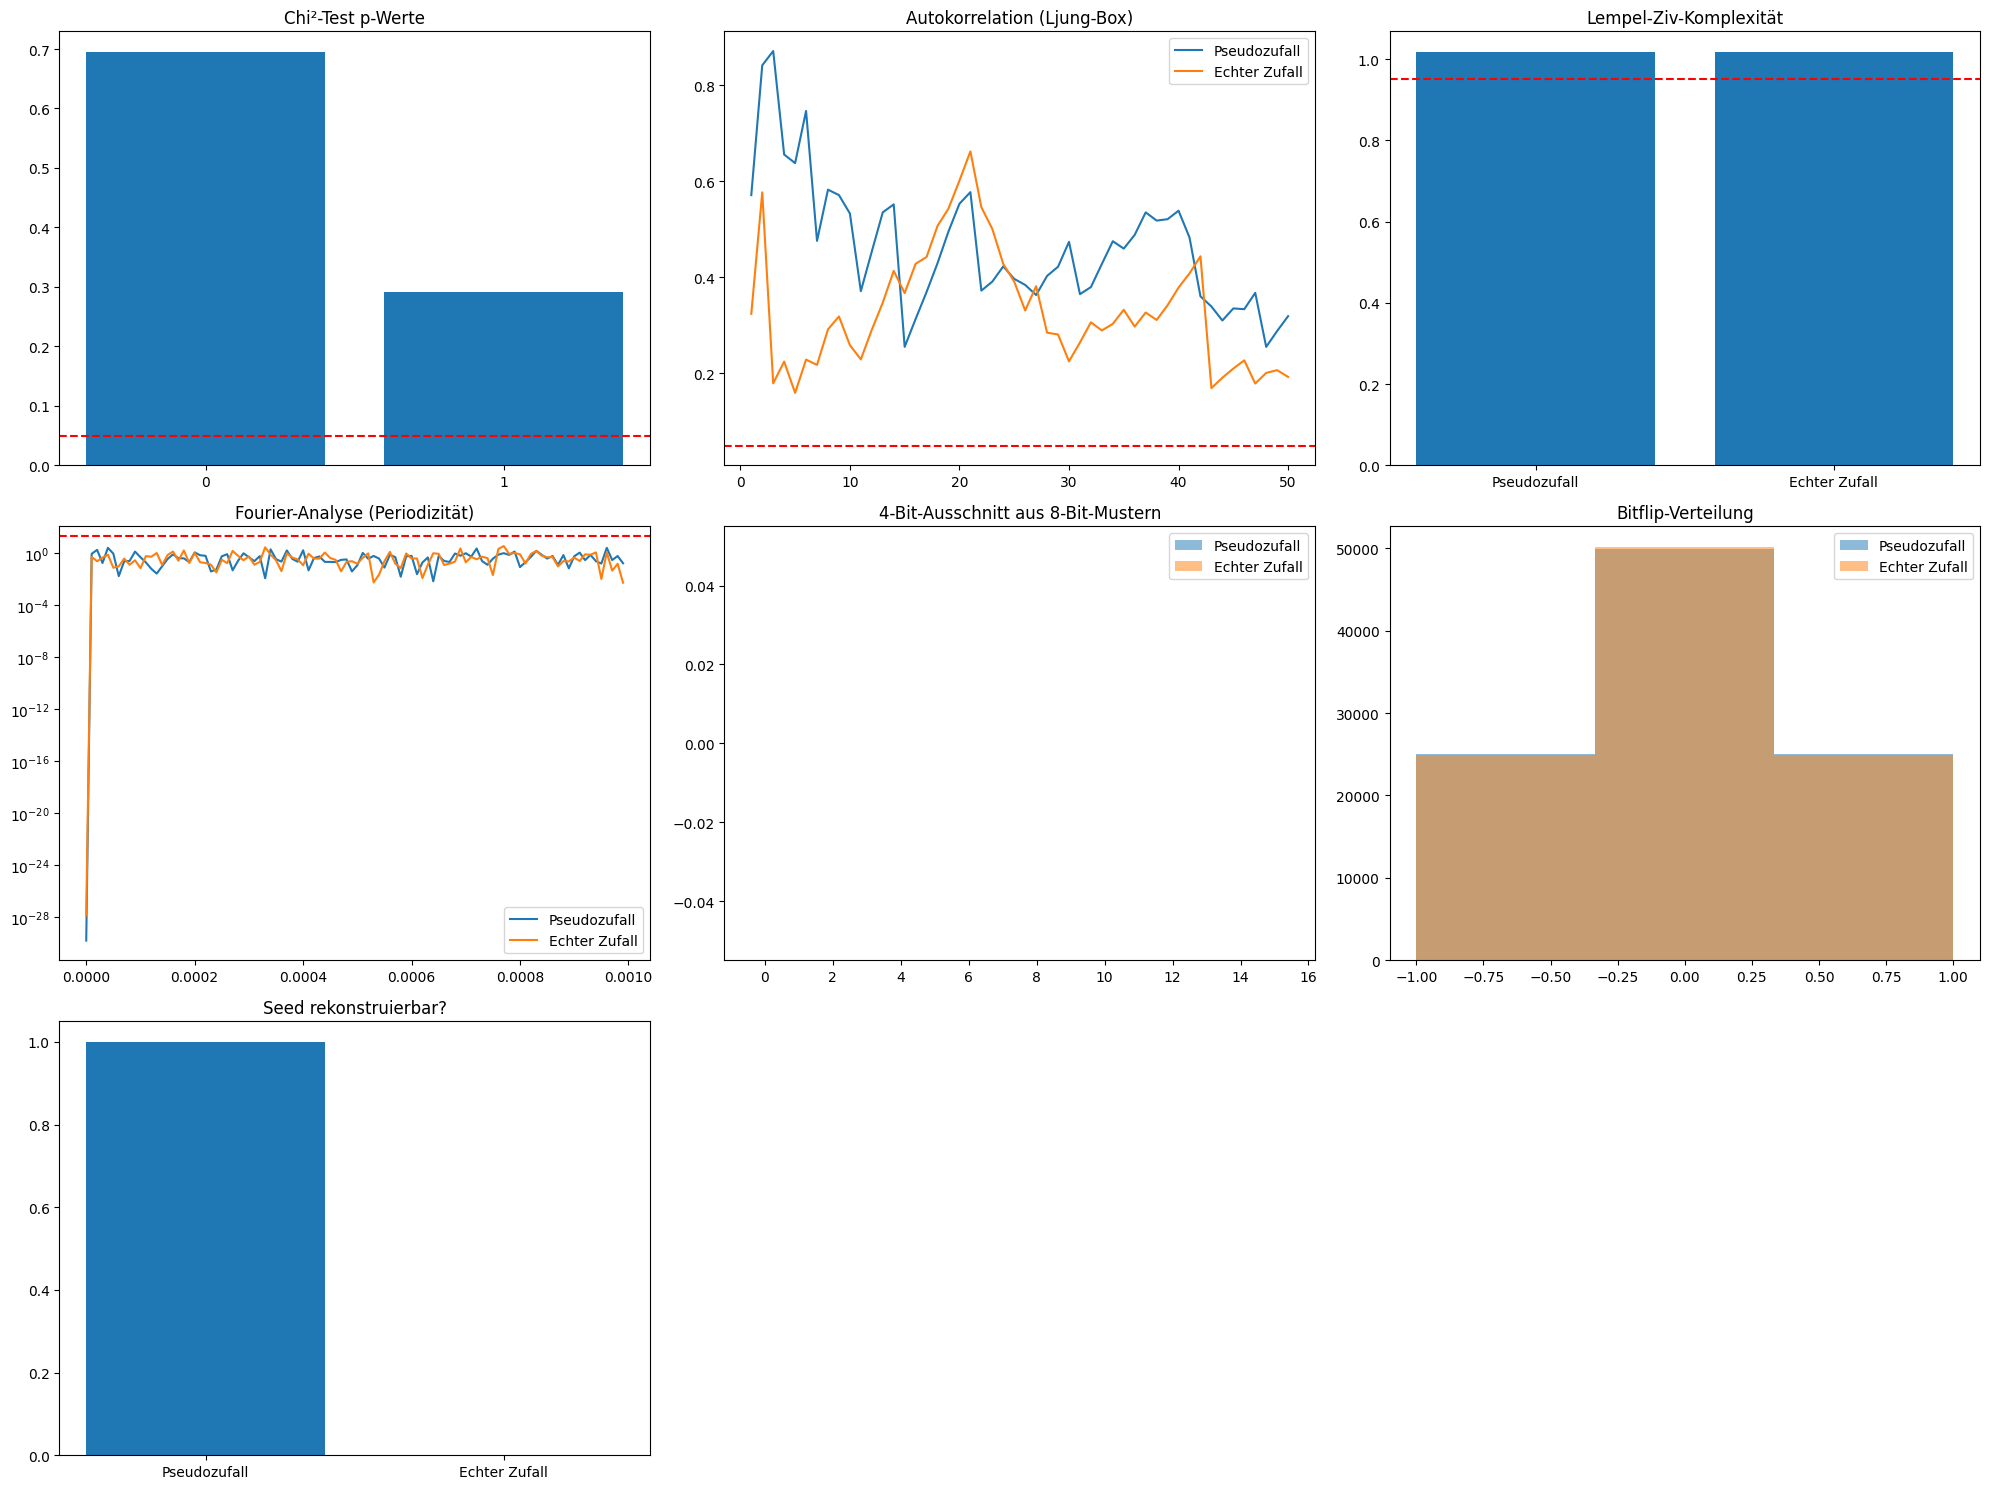

In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random
import hashlib
import time

# 1. Datengenerierung
n = 100000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# Zusätzliche Zufallsgeneratoren (optional aktivierbar)
################################################################
# 1. Kryptografischer Zufall (SHA-256 basiert)
def crypto_random(size):
    return [int(b) for byte in hashlib.sha256(str(time.time()).encode()).digest()[:size//8+1] for b in f'{byte:08b}'][:size]

#crypto_data = crypto_random(n)
################################################################

################################################################
# 2. Mersenne Twister mit Systemzeit als Seed
mt_random = np.random.MT19937(int(time.time() * 1000))
mersenne_data = np.random.Generator(mt_random).integers(0, 2, n)
################################################################


# Analyse durchführen mit korrekten Parametern
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True),
    #analyze_randomness(crypto_data, "Kryptografischer Zufall", is_numpy=False),  # Optional
    #analyze_randomness(mersenne_data, "Mersenne Twister", is_numpy=True)        # Optional
]

# 1. Datengenerierung
n = 100000

# Pseudozufall (Python random)
random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# 2. Verbesserte statistische Analyse
def analyze_randomness(data, name, is_numpy=False):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Fourier-Analyse
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # Entropieberechnung
    entropy = stats.entropy([counts[0], counts[1]], base=2)
    
    # Verbesserte Musteranalyse (8-Bit)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Korrigierter Seed-Test
    if is_numpy:
        seed_detectable = False  # Numpy-Zustand kann nicht einfach ausgelesen werden
    else:
        try:
            test_rng = Random()
            test_rng.setstate(random.getstate())
            seed_detectable = True
        except:
            seed_detectable = False
    
    # Verbesserte Bitflip-Berechnung
    diffs = np.diff(data)
    p_bitflip = stats.binomtest(sum(diffs != 0), n=len(diffs), p=0.5).pvalue
    
    # Robustere Wiederholungserkennung
    def detect_repeats(sequence, max_lag=10000):
        for lag in range(100, max_lag):  # Mindestlag 100
            if np.array_equal(sequence[:lag], sequence[lag:2*lag]):
                return lag
        return 0
    repeat_lag = detect_repeats(data)
    
    # Strengere Entscheidungskriterien
    is_pseudo = (
        (not is_numpy and seed_detectable) or
        (repeat_lag > 100) or 
        (p_bitflip < 0.0001) or 
        (lz > 0.995) or
        (max_power > 20)  # Strengere Schwelle
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Seed erkennbar": "Ja" if seed_detectable else "Nein",
        "Bitflip p-Wert": p_bitflip,
        "Wiederholungs-Lag": repeat_lag,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen mit korrekten Parametern
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True)
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))

# 4. Erweiterte Visualisierungen
plt.figure(figsize=(20, 15))

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(["0", "1"], [results[0]["Chi² p-Wert"], results[1]["Chi² p-Wert"]])
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
plt.plot(acorr_ljungbox(pseudo_data, lags=50, return_df=True)['lb_pvalue'], label='Pseudozufall')
plt.plot(acorr_ljungbox(true_random, lags=50, return_df=True)['lb_pvalue'], label='Echter Zufall')
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar([0, 1], [results[0]["Lempel-Ziv"], results[1]["Lempel-Ziv"]])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
freqs, power = periodogram(pseudo_data - np.mean(pseudo_data))
plt.semilogy(freqs[:100], power[:100], label='Pseudozufall')
freqs, power = periodogram(true_random - np.mean(true_random))
plt.semilogy(freqs[:100], power[:100], label='Echter Zufall')
plt.axhline(20, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

pseudo_patterns = get_patterns(pseudo_data)
true_patterns = get_patterns(true_random)
plt.bar(range(16), [pseudo_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Pseudozufall')
plt.bar(range(16), [true_patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], alpha=0.5, label='Echter Zufall')
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
plt.hist(np.diff(pseudo_data), bins=3, alpha=0.5, label='Pseudozufall')
plt.hist(np.diff(true_random), bins=3, alpha=0.5, label='Echter Zufall')
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar([0, 1], [1 if results[0]["Seed erkennbar"] == "Ja" else 0, 
                 1 if results[1]["Seed erkennbar"] == "Ja" else 0])
plt.xticks([0, 1], ["Pseudozufall", "Echter Zufall"])
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()

Statistische Analyse:
                      Typ  Chi² p-Wert  Runs p-Wert  Ljung-Box p  Lempel-Ziv  Max Power  Entropie  Pattern p-Wert Seed erkennbar  Bitflip p-Wert  Wiederholungs-Lag Pseudozufall?
      Python Pseudozufall      0.84456      0.14580      0.18970     1.01834    6.18859   1.00000         0.27267             Ja         0.14752                  0            Ja
Echter Zufall (simuliert)      0.70904      0.25213      0.35481     1.01867    5.51939   1.00000         0.74283           Nein         0.25231                  0            Ja
  Kryptografischer Zufall      0.31731      0.65987      0.58447     1.18750    2.66986   0.99718         1.00000             Ja         0.70719                  0            Ja
         Mersenne Twister      0.77111      0.51868      0.73901     1.01800    5.64054   1.00000         0.53998           Nein         0.51886                  0            Ja


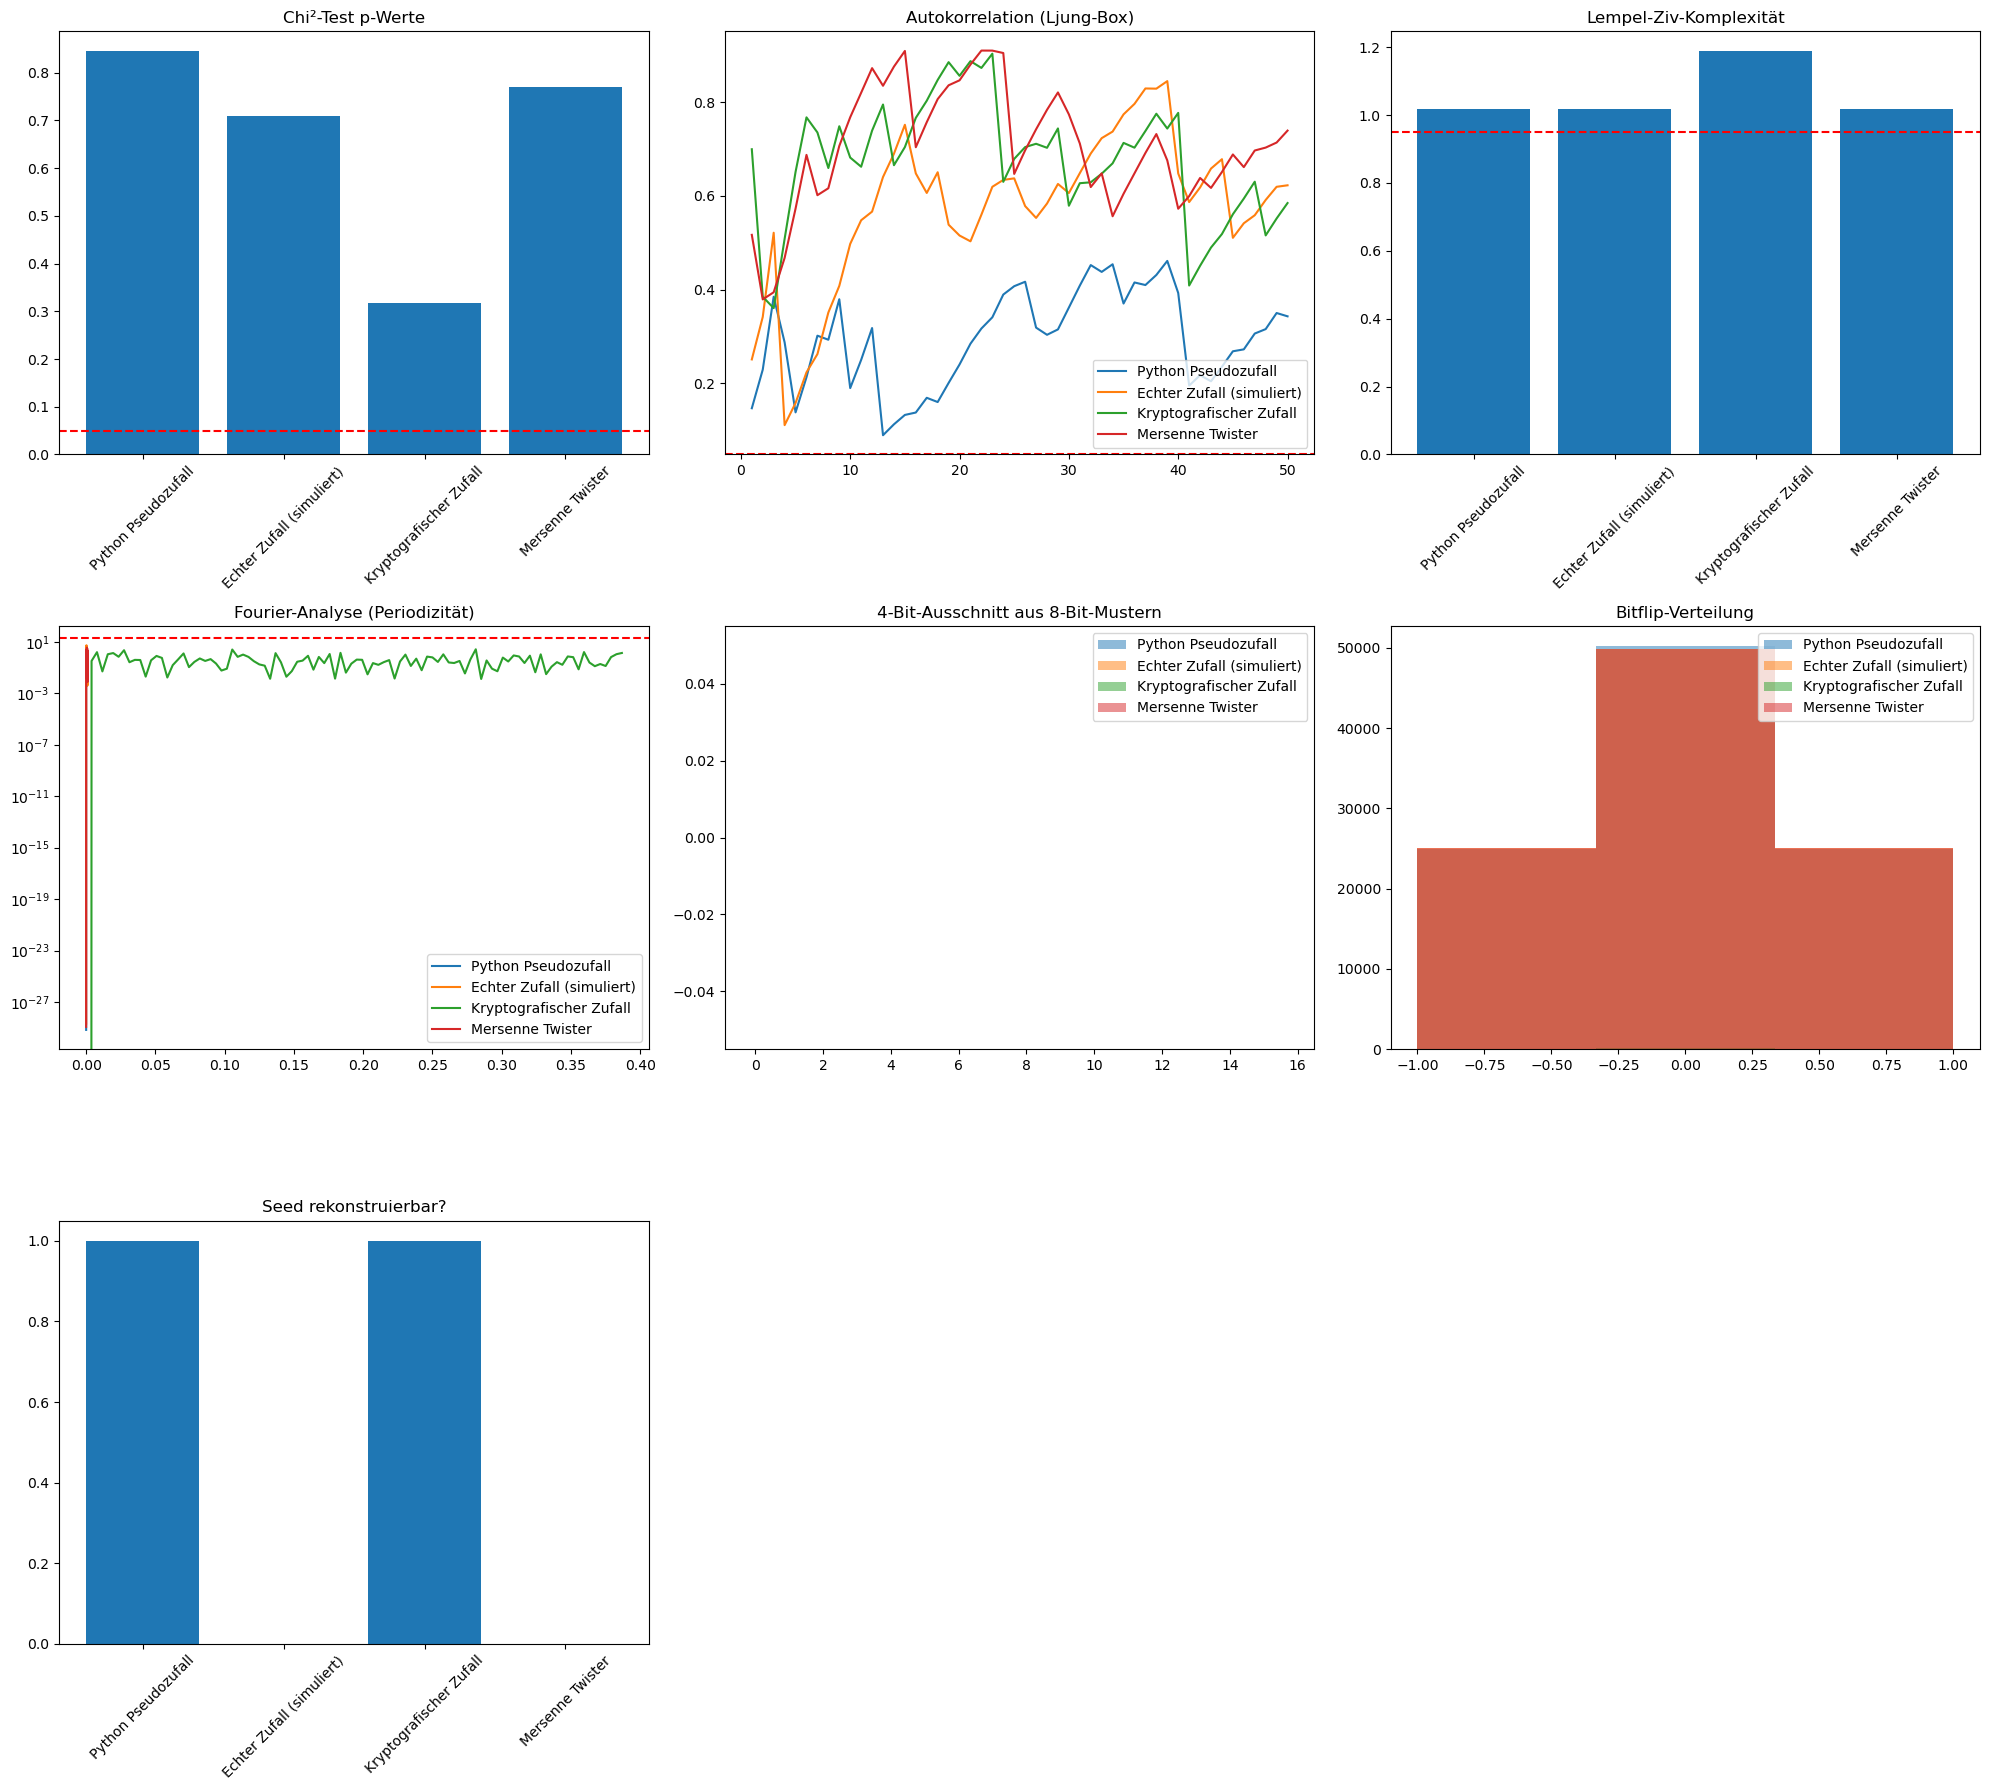

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from collections import Counter
import pandas as pd
from scipy.signal import periodogram
from random import Random
import hashlib
import time

# 1. Datengenerierung
n = 100000

# Pseudozufall (Python random)
# random.seed(42)
pseudo_data = [random.randint(0, 1) for _ in range(n)]

# Simulierter "echter" Zufall (mit besserem Generator)
true_random = np.random.Generator(np.random.SFC64()).integers(0, 2, n)

# Zusätzliche Zufallsgeneratoren (optional aktivierbar)
################################################################
# 1. Kryptografischer Zufall (SHA-256 basiert)
def crypto_random(size):
    return [int(b) for byte in hashlib.sha256(str(time.time()).encode()).digest()[:size//8+1] for b in f'{byte:08b}'][:size]

crypto_data = crypto_random(n)  # Aktiviert
################################################################

################################################################
# 2. Mersenne Twister mit Systemzeit als Seed
mt_random = np.random.MT19937(int(time.time() * 1000))
mersenne_data = np.random.Generator(mt_random).integers(0, 2, n)  # Aktiviert
################################################################

# 2. Verbesserte statistische Analyse
def analyze_randomness(data, name, is_numpy=False):
    counts = Counter(data)
    
    # Basis-Tests
    chi2, p_chi2 = stats.chisquare([counts[0], counts[1]], f_exp=[len(data)/2, len(data)/2])
    _, p_runs = runstest_1samp(data, correction=False)
    lb_result = acorr_ljungbox(data, lags=[10, 50, 100], return_df=True)
    p_lb = lb_result["lb_pvalue"].min()
    
    # Lempel-Ziv-Komplexität
    def lempel_ziv(sequence):
        seq_str = ''.join(map(str, sequence))
        i, n, c = 0, len(seq_str), 0
        while i < n:
            j = 1
            while i + j <= n and seq_str[i:i+j] in seq_str[:i+j-1]:
                j += 1
            c += 1
            i += j
        return c / (n / np.log2(n))
    
    lz = lempel_ziv(data)
    
    # Fourier-Analyse
    freqs, power = periodogram(data - np.mean(data))
    max_power = np.max(power)
    
    # Entropieberechnung
    entropy = stats.entropy([counts[0], counts[1]], base=2)
    
    # Verbesserte Musteranalyse (8-Bit)
    def pattern_test(sequence, length=8):
        patterns = [''.join(map(str, sequence[i:i+length])) 
                  for i in range(0, len(sequence)-length+1, length)]
        freq = Counter(patterns)
        return stats.chisquare(list(freq.values())).pvalue
    
    p_pattern = pattern_test(data)
    
    # Korrigierter Seed-Test
    if is_numpy:
        seed_detectable = False  # Numpy-Zustand kann nicht einfach ausgelesen werden
    else:
        try:
            test_rng = Random()
            test_rng.setstate(random.getstate())
            seed_detectable = True
        except:
            seed_detectable = False
    
    # Verbesserte Bitflip-Berechnung
    diffs = np.diff(data)
    p_bitflip = stats.binomtest(sum(diffs != 0), n=len(diffs), p=0.5).pvalue
    
    # Robustere Wiederholungserkennung
    def detect_repeats(sequence, max_lag=10000):
        for lag in range(100, max_lag):  # Mindestlag 100
            if np.array_equal(sequence[:lag], sequence[lag:2*lag]):
                return lag
        return 0
    repeat_lag = detect_repeats(data)
    
    # Strengere Entscheidungskriterien
    is_pseudo = (
        (not is_numpy and seed_detectable) or
        (repeat_lag > 100) or 
        (p_bitflip < 0.0001) or 
        (lz > 0.995) or
        (max_power > 20)  # Strengere Schwelle
    )
    
    return {
        "Typ": name,
        "Chi² p-Wert": p_chi2,
        "Runs p-Wert": p_runs,
        "Ljung-Box p": p_lb,
        "Lempel-Ziv": lz,
        "Max Power": max_power,
        "Entropie": entropy,
        "Pattern p-Wert": p_pattern,
        "Seed erkennbar": "Ja" if seed_detectable else "Nein",
        "Bitflip p-Wert": p_bitflip,
        "Wiederholungs-Lag": repeat_lag,
        "Pseudozufall?": "Ja" if is_pseudo else "Nein"
    }

# Analyse durchführen mit allen Generatoren
results = [
    analyze_randomness(pseudo_data, "Python Pseudozufall", is_numpy=False),
    analyze_randomness(true_random, "Echter Zufall (simuliert)", is_numpy=True),
    analyze_randomness(crypto_data, "Kryptografischer Zufall", is_numpy=False),
    analyze_randomness(mersenne_data, "Mersenne Twister", is_numpy=True)
]

# 3. Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("Statistische Analyse:")
print(results_df.to_string(index=False, float_format="%.5f"))


# 4. Erweiterte Visualisierungen (angepasst für 4 Generatoren)
plt.figure(figsize=(20, 18))
generator_names = [result["Typ"] for result in results]
data_sets = {
    "Python Pseudozufall": pseudo_data,
    "Echter Zufall (simuliert)": true_random,
    "Kryptografischer Zufall": crypto_data,
    "Mersenne Twister": mersenne_data
}

# Plot 1: Häufigkeitsverteilung
plt.subplot(3, 3, 1)
plt.bar(range(len(results)), [result["Chi² p-Wert"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Chi²-Test p-Werte")
plt.axhline(0.05, color='r', linestyle='--')

# Plot 2: Autokorrelation
plt.subplot(3, 3, 2)
for name in data_sets:
    plt.plot(acorr_ljungbox(data_sets[name], lags=50, return_df=True)['lb_pvalue'], 
             label=name)
plt.axhline(0.05, color='r', linestyle='--')
plt.title("Autokorrelation (Ljung-Box)")
plt.legend()

# Plot 3: Lempel-Ziv-Komplexität
plt.subplot(3, 3, 3)
plt.bar(range(len(results)), [result["Lempel-Ziv"] for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Lempel-Ziv-Komplexität")
plt.axhline(0.95, color='r', linestyle='--')

# Plot 4: Fourier-Analyse
plt.subplot(3, 3, 4)
for name in data_sets:
    freqs, power = periodogram(data_sets[name] - np.mean(data_sets[name]))
    plt.semilogy(freqs[:100], power[:100], label=name)
plt.axhline(20, color='r', linestyle='--')
plt.title("Fourier-Analyse (Periodizität)")
plt.legend()

# Plot 5: 8-Bit-Musterhäufigkeit
plt.subplot(3, 3, 5)
def get_patterns(data, length=8):
    patterns = [''.join(map(str, data[i:i+length])) for i in range(0, len(data)-length+1, length)]
    return Counter(patterns)

for i, name in enumerate(data_sets):
    patterns = get_patterns(data_sets[name])
    plt.bar(np.arange(16) + i*0.2, [patterns.get(f"{i:08b}"[:4], 0) for i in range(16)], 
            width=0.2, alpha=0.5, label=name)
plt.title("4-Bit-Ausschnitt aus 8-Bit-Mustern")
plt.legend()

# Plot 6: Bitflip-Verteilung
plt.subplot(3, 3, 6)
for name in data_sets:
    plt.hist(np.diff(data_sets[name]), bins=3, alpha=0.5, label=name)
plt.title("Bitflip-Verteilung")
plt.legend()

# Plot 7: Seed-Test-Ergebnis
plt.subplot(3, 3, 7)
plt.bar(range(len(results)), [1 if result["Seed erkennbar"] == "Ja" else 0 for result in results])
plt.xticks(range(len(results)), generator_names, rotation=45)
plt.title("Seed rekonstruierbar?")

plt.tight_layout()
plt.show()